In [24]:
#В качестве датасета выбран набор данных о винах: https://www.kaggle.com/datasets/zynicide/wine-reviews
#нужно создать модели МО, используя регрессию, классификацию, кластеризацию

# Загружаем библиотеки
import numpy as np # работа с векторами
import matplotlib.pyplot as plt # рисовать графики
import pandas as pd # для работы с табличная
import sklearn # машинное обучение на python
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [6]:
# загружаем данные
dataset = pd.read_csv('winemag-data_first150k.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


## Обработка данных

в загруженных данных мы имеем следующие параметры/столбцы: 
1. country - страна производства, 
2. description - опиание, 
3. designation - название вина, 
4. points - оценка вина, 
5. price - цена, 
6. province - провинция страны производства, 
7. region_1 - 1-й регион сбора винограда, 
8. region_2 - 2-й регион сбора винограда, 
9. variety - вид вина, 
10. winery - винодельня

Так как понятие описания вина очень специфичное и трудно поддается обработке, мы удалим данный столбец. 
Также стоит удалить столбец region_2 из-за большого количество пропусков

In [7]:
dataset = dataset.drop(columns = ['description', 'region_2'])
#удаляем первый столбец. Нам не нужна нумерация
dataset = dataset.drop(dataset.columns[0], axis=1)

In [8]:
#такие поля как designation, province, region_1, variety, winery имеют категориальный вид и с ними будет сложно работать. 
#Нужно их категоризовать и нормализовать

# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

dataset['country_encoded'] = label_encoder.fit_transform(dataset['country'])
dataset['name'] = label_encoder.fit_transform(dataset['designation'])
dataset['province_encoded'] = label_encoder.fit_transform(dataset['province'])
dataset['region'] = label_encoder.fit_transform(dataset['region_1'])
dataset['variety_encoded'] = label_encoder.fit_transform(dataset['variety'])
dataset['winery_encoded'] = label_encoder.fit_transform(dataset['winery'])


dataset = dataset.drop(columns = ['country','designation', 'province', 'region_1', 'variety', 'winery'])


In [9]:
#переименуем в человеческий вид
new_column_names = {
    'country_encoded': 'country',
    'province_encoded': 'province',
    'variety_encoded': 'variety',
    'winery_encoded': 'winery'
}
dataset.rename(columns=new_column_names, inplace=True)

In [10]:
#нормализация данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)
dataset = pd.DataFrame(scaled_data, columns=dataset.columns)

Пустые значения встречаются только в name, price, region. Проверить это можно через print(dataset['points'].isnull().any())
Значение price можно попробовать восстановить используя КК, на основе параметра points. А вот пустые строки у name и region лучше удалить, что бы снизить значение предсказания в будущем

In [11]:
# Вычислим коэффициент корреляции
#correlation = dataset['points'].corr(dataset['price'])
# Заполним пропуски в столбце 'price' на основе значений в столбце 'points' с учетом коэффициента корреляции
#dataset['price'].fillna(dataset['points'] * correlation, inplace=True)

Коэффициент корреляции показал страшные значения, поэтому лучше удалим. Ниже можно глянуть общий разброс этих значений

31    0.014373

32    0.229932

33    0.007840

34    0.016551

35    0.057056

36    0.024390

37    0.010889

38    0.008275

39    0.010889

In [12]:
#удалим все пустые строки
dataset = dataset.dropna()

## Формулировка задач

Исходя из столбцов в датасете, можно сформулировать следующие задачи:

1. **Регрессионный анализ**:

   Прогнозирование баллов (points) вина на основе его цены (price), разновидности (variety) и области происхождения (region).

2. **Классификация**:

   Классификация вин по стране происхождения (country) на основе их разновидности (variety), цены (price) и области происхождения (region).

3. **Кластеризация**:

   Кластеризация вин на основе их характеристик, таких как разновидность (variety), область происхождения (region) и винодельня (winery), с целью выявления групп схожих вин.


## Задача регрессии

### Прогнозирование баллов (points) вина на основе его цены (price), разновидности (variety) и области происхождения (region).

In [13]:
# Выделим признаки и целевую переменную
X = dataset[['price', 'variety', 'region']]
y = dataset['points']

# Разделим данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=5)

# Создаем модель линейной регрессии
model = LinearRegression()

# Обучаем модель на обучающей выборке
model.fit(X_train, y_train)

# Делаем прогноз на тестовом наборе
y_pred = model.predict(X_test)

# Оцениваем производительность модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.02187529485412629
R-squared: 0.16073410544762323


### Задача Регрессии. Промежуточные результаты
Mean Squared Error: 0.02187529485412629
R-squared: 0.16073410544762323

MSE измеряет среднее значение квадратов разностей между фактическими и предсказанными значениями.В нашем случае, MSE равно 0.0219, что довольно низкое значение. Это означает, что модель имеет небольшую ошибку в прогнозировании баллов на основе цены, разновидности и области происхождения.

R-squared измеряет процент дисперсии в зависимой переменной, который объясняется независимыми переменными в модели. В нашем случае, R-squared равно 0.161, что означает, что модель объясняет всего 16.1% дисперсии в баллах вина на основе цены, разновидности и области происхождения. Это относительно низкое значение и может указывать на то, что модель не очень хорошо объясняет вариацию в данных.


In [15]:
# Попробуем решить задачи регрессии используя случайный лес
# Создадим модель случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучим модель на обучающем наборе
model.fit(X_train, y_train)

# Сделаем прогноз на тестовом наборе
y_pred = model.predict(X_test)

# Оценим производительность модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.012423508694510702
R-squared: 0.5233606126222796


### Задача Регрессии. Итоговые результаты

Mean Squared Error: 0.012423508694510702
R-squared: 0.5233606126222796

После выбора другого, более сложного алгоритма регрессии -- Случайные лес. Мы получили гораздно лучше резльтат по сравнению с линейной регрессией, а именно значение параметра увеличилось на 36% и составило 0.52, а значение средне квадратической ошибки уменьшилось в 3 раза и составила 0.01. С такой моделью мы можем пользоваться. В качестве дальнейшего увеления значения предсказания, можно заюзать уже более сложные алгоритмы -- нейронные сети или попробовать изменить нецелевые признаки для обучения.


## Задача классификации

### Классификация вин по стране происхождения (country) на основе их разновидности (variety), цены (price) и области происхождения (region).

In [16]:
#Чтобы решить задачу классификации, воспользуемся сначала алгоритмом случайного леса
# Выделим признаки и целевую переменную
X = dataset[['variety', 'price', 'region']]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['country'])

X = pd.get_dummies(X, drop_first=True)

# Разделим данные на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Создадим модель случайного леса для классификации
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучим модель на обучающем наборе
model.fit(X_train, y_train)

# Сделаем прогноз на тестовом наборе
y_pred = model.predict(X_test)

In [17]:
# Оценим производительность модели
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)
#Смотреть на Confusion Matrix думаю не имеет смысла, так как итого у нас получается 45 классов и по матрице сложно будет сделать вывод. 
#Поэтому будем анализировать по Classification Report
#print("Confusion Matrix:")
#print(conf_matrix)
# Построение Confusion Matrix визуально
#plt.figure(figsize=(10, 8))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()

Accuracy: 0.9278974022661858
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.96      1111
           2       0.94      0.91      0.93       982
           3       0.90      0.64      0.75       483
           4       0.50      1.00      0.67         1
           5       1.00      0.25      0.40         4
           6       0.50      0.09      0.15        11
           7       0.93      0.80      0.86        35
           8       0.66      0.77      0.71      1119
           9       1.00      0.00      0.00         1
          10       0.67      0.29      0.40        14
          11       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          14       0.97      0.96      0.96      2979
          15       1.00      0.30      0.46        10
          16       0.72      0.90      0.80       483
          17       0.63      0.50      0.55       173
          18       0.63      

### Задача классификации. Промежуточные результаты

Classification Report предоставляет информацию о точности, полноте и F1-мере для каждого класса в задаче классификации. В данном случае у нас множество классов (стран происхождения вина), и Classification Report отражает производительность модели для каждого из них. F1-мера - это метрика, которая объединяет точность (precision) и полноту (recall) в одну метрику для оценки производительности модели классификации.

#### Оценка качества классификации:

- **Accuracy**: 0.93 (93%) - Это доля правильно классифицированных образцов от общего числа образцов в тестовом наборе. Этот признак дает плывучее представление о точности нашей модели, поэтому рассмотрим и другие параметры.

#### Оценка по каждому классу (стране происхождения):

Класс "1": Точность (Precision) - 0.97, Полнота (Recall) - 0.96, F1-мера - 0.96. Это означает, что 97% объектов, предсказанных как класс "1", действительно принадлежат к этому классу, и модель обнаруживает 96% объектов этого класса. И так для каждого класса

#### Макро-усреднение и взвешенное усреднение:

- **Макро-усреднение (macro avg)**: Это средние значения для всех классов. В данном случае средняя точность - 0.74, средняя полнота - 0.51, средняя F1-мера - 0.60.

- **Взвешенное усреднение (weighted avg)**: Это средние значения, учитывая размеры классов. В данном случае взвешенная точность - 0.93, взвешенная полнота - 0.93, взвешенная F1-мера - 0.93.

#### Итого:

- Модель имеет высокую точность (Precision) и полноту (Recall) для классов "1" и "14", что означает, что она хорошо идентифицирует объекты этих классов.

- У классов с низкой точностью или полнотой (например, класс "3" или класс "9") может быть недостаточно данных для точного прогноза, или модель может испытывать трудности в их идентификации.

- Взвешенное усреднение (weighted avg) показывает, что модель имеет хорошую среднюю производительность по всем классам.


In [18]:
#Попробуем решить задачу классификации используя алгоритм k-ближ соседей и сопоставим результаты
X = dataset[['variety', 'price', 'region']]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['country'])

X = pd.get_dummies(X, drop_first=True)

# Разделим данные на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Создадим модель K-Nearest Neighbors
model = KNeighborsClassifier(n_neighbors=8)  # Здесь n_neighbors - количество соседей для классификации

# Обучим модель на обучающем наборе
model.fit(X_train, y_train)

# Сделаем прогноз на тестовом наборе
y_pred = model.predict(X_test)

# Оценим производительность модели
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.9104820198928845
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.92      0.92      1111
           2       0.89      0.89      0.89       982
           3       0.82      0.64      0.72       483
           4       1.00      0.00      0.00         1
           5       1.00      0.00      0.00         4
           6       0.33      0.09      0.14        11
           7       0.83      0.83      0.83        35
           8       0.64      0.77      0.70      1119
           9       1.00      0.00      0.00         1
          10       0.60      0.21      0.32        14
          11       1.00      0.00      0.00         2
          13       0.00      0.00      1.00         1
          14       0.95      0.95      0.95      2979
          15       0.60      0.60      0.60        10
          16       0.70      0.91      0.79       483
          17       0.62      0.49      0.55       173
          18       0.40      

#### Используя метод к ближайщих соседей, с параметром k = 5, я получил следующие значения

accuracy                               0.92     27447

macro avg          0.74      0.40      0.47     27447

weighted avg       0.92      0.92      0.92     27447

#### Эти результаты примерно на 1% ниже, чем резы полученнные алгоритмом случайного леса, Попробуем увеличть и уменьшить значение k на 3 и посмотрим резы:

##### Резы При к = 2:

accuracy                               0.93     27447

macro avg          0.68      0.49      0.50     27447

weighted avg       0.93      0.93      0.93     27447

##### Резы При к = 8:

accuracy                               0.91     27447
macro avg          0.79      0.37      0.42     27447
weighted avg       0.91      0.91      0.91     27447

#### Как видно из результатов при использовании алгоритма к ближайщих соседей наши результаты не лучше чем при использовании алгоритма случайного леса. Уступаем только в параметре macro avg. Для алгоритма случайного леса = 0.6, для к ближ соседей = 0.46, что очень сильно низко. Попробуем решить задачу классификации с использованием логистической регрессии

In [19]:
# 1. Загрузка данных и предварительная обработка
X = dataset[['variety', 'price', 'region']]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['country'])

# Применим one-hot encoding к категориальному признаку 'country'
X = pd.get_dummies(X, drop_first=True)

# Разделение данных на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# 2. Создание и обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 3. Прогнозы на тестовом наборе
y_pred = model.predict(X_test)

# 4. Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.46992385324443475
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00      1111
           2       1.00      0.00      0.00       982
           3       1.00      0.00      0.00       483
           4       1.00      0.00      0.00         1
           5       1.00      0.00      0.00         4
           6       1.00      0.00      0.00        11
           7       1.00      0.00      0.00        35
           8       0.35      0.61      0.45      1119
           9       1.00      0.00      0.00         1
          10       1.00      0.00      0.00        14
          11       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          14       0.64      0.02      0.04      2979
          15       1.00      0.00      0.00        10
          16       0.40      0.00      0.01       483
          17       1.00      0.00      0.00       173
          18       1.00     

### Задача классификации. Итоговые результаты

При использовании алгоритма логистической регресии для этой задачи были получены следующие значения ... и они кончено удивили. Пришлось конечно даже увеличить кол-во итераций до 1000

accuracy                               0.47     27447

macro avg          0.93      0.04      0.03     27447

weighted avg       0.67      0.47      0.33     27447

Значения получились очень низкие по сравнению с алгоритмом к-ближайших соседей и алгоритма случайного леса. Поэтому в данной задаче лучше не использовать данный алгоритм или попробовать изменить нецелевые признаки

## Задача кластеризации

### Кластеризация вин на основе их характеристик, таких как разновидность (variety), область происхождения (region) и винодельня (winery), с целью выявления групп схожих вин.

In [20]:
print(dataset.head())

   points     price   country      name  province    region   variety  \
0    0.80  0.100610  0.916667  0.564057  0.112088  0.597087  0.110935   
1    0.80  0.046167  0.833333  0.143660  0.602198  0.865696  0.876387   
2    0.80  0.037456  0.916667  0.828941  0.112088  0.427184  0.741680   
3    0.80  0.026568  0.916667  0.728520  0.619780  0.988673  0.637084   
4    0.75  0.027003  0.312500  0.465726  0.687912  0.053398  0.668780   

     winery  
0  0.492066  
1  0.083125  
2  0.609967  
3  0.742927  
4  0.365318  


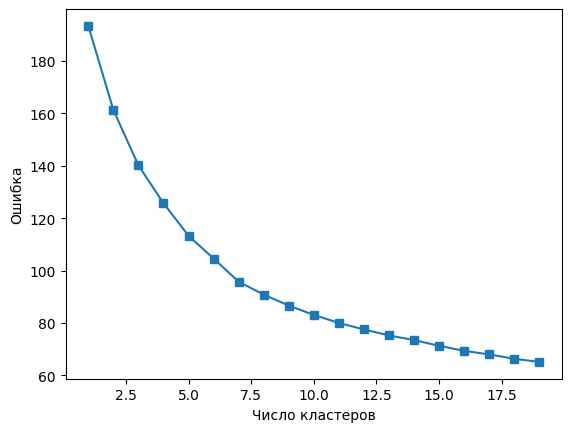

In [26]:
X = dataset[['variety', 'region', 'winery']]
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Ошибка');

#### Кластеризация. Промежуточные результаты

В коде выше решили вычислить меру суммы квадратов расстояний между точками данных и их ближайшими центроидами кластеров для каждого значения к от 1 до 20. В иделае значение этой ошибки должно быть маленькой. На графике выше можно увидеть что чилсе класторов начиная от 17, ошибка приближается к 60. В следующем коде, мы запустим заново этот алгоритм на значениях к [20, 40] и посмотрим сильно ли уменьшится значение ошибки или оно просто застынет на некотором значении

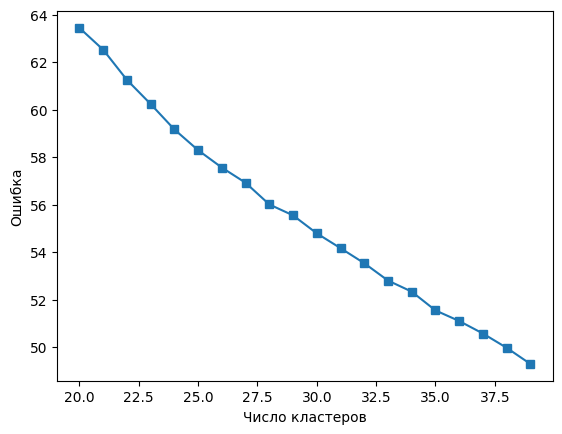

In [30]:
inertia = []
for k in range(20, 40):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(20, 40), inertia, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Ошибка');

На графике выше видно, что значение ошибки начала уменьшаться линейно и упало с 60 до 50. Раз значение ошибки так быстро, практически линейно падает, попробуем интервал с к [60: 80]

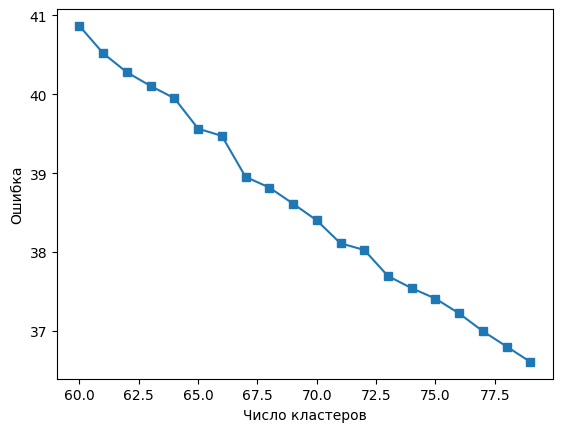

In [32]:
inertia = []
for k in range(60, 80):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(60, 80), inertia, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Ошибка');

В интервале к [60: 80] мы видим что ошибка начала хоть и линейно уменьшаться, но само значение не сильно падает. Выбранное значение k (80) может быть оптимальным для данного набора данных. Это может быть наилучшим способом разделения данных, и дальнейшее увеличение числа кластеров не приносит значительного улучшения в качестве кластеризации.

In [33]:
kmeans = KMeans(n_clusters=80, random_state=1, n_init=10).fit(X)
#распределение количества наблюдений по кластерам в кластеризации по параметрам регрессии
[len(kmeans.labels_[kmeans.labels_ == i]) for i in range(80)]

[1516,
 1227,
 3138,
 1700,
 2930,
 2024,
 1652,
 938,
 1616,
 1640,
 1472,
 1287,
 1655,
 1268,
 1847,
 1320,
 2509,
 1710,
 1270,
 1930,
 899,
 1468,
 919,
 2850,
 1562,
 1064,
 1514,
 2781,
 1172,
 1372,
 1624,
 1323,
 2044,
 2408,
 2320,
 2747,
 2604,
 2324,
 2544,
 963,
 2684,
 1324,
 1292,
 681,
 1242,
 680,
 1931,
 3572,
 1623,
 1640,
 1622,
 1306,
 1570,
 826,
 1165,
 2409,
 1210,
 1701,
 2033,
 1522,
 1954,
 2731,
 958,
 2214,
 2005,
 908,
 2102,
 1259,
 2158,
 2255,
 1149,
 1628,
 1142,
 1195,
 1674,
 1781,
 2105,
 2052,
 1745,
 1036]

#### Кластеризация. Итоговые результаты

Результаты показывают, как количество наблюдений распределено по 80 кластерам после применения алгоритма K-Means. Важно заметить, что распределение неравномерное, и количество наблюдений в разных кластерах значительно различается. Некоторые кластеры имеют гораздо больше наблюдений, чем другие.

Это может иметь следующие практические следствия:

1. **Неравномерность групп вин:** Некоторые группы вин (кластеры) более представительны, чем другие. Это может быть важным для понимания, какие разновидности вин, регионы и винодельни чаще встречаются.

2. **Анализ крупных и малых групп:** Мы можем проанализировать характеристики и особенности вин в крупных и малых кластерах отдельно. Это может помочь выявить, что делает каждую из этих групп уникальной.

3. **Выбор представительных объектов:** Мы можем выбрать несколько представительных вин из каждого кластера для дополнительного анализа. Это может помочь вам понять, какие вина характерны для каждой группы.